In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import math
import random
from scipy.stats import binom
import os
import openpyxl
import matplotlib.pyplot as plt
SFHH = pd.read_csv('E:/Desktop/毕业论文/论文1/data/tij_SFHH/202306.csv',names = ['time','i','j'],header = None)
ij = pd.read_csv('E:/Desktop/毕业论文/论文1/data/tij_SFHH/202306label.csv',names = ['lable'],header = None)

In [2]:
def mynetwork(mydata,t,b):    ##数据集 ，节点集，时间间隔，滑动多少
    MYG = nx.Graph()
    MYG.add_nodes_from(ij['lable'])
    for i in range(len(mydata)):
        if mydata['time'][i] >= mydata['time'][0]+b:
            if mydata['time'][i] <= mydata['time'][0]+b+ t:
                MYG.add_edge(mydata['i'][i],mydata['j'][i])
            else:
                break                
    return MYG
t = 1800   ###一次选取30分钟的数据
b = 60 #滑动1分钟
data_n = 1200

nodes_n = np.zeros(data_n)
edges_n = np.zeros(data_n)
G = np.empty(data_n,dtype = object)
A = np.empty(data_n,dtype = object)
#G = np.concatenate(G, axis=0)
for N in range(data_n):
        
    G[N] = mynetwork(SFHH,t,N*b)
    A[N] = np.array(nx.adjacency_matrix(G[N]).todense())  
    edges_n[N] = len(G[N].edges())
    

pd.DataFrame(A).to_csv('E:\\Desktop\\毕业论文\\论文1\\202307结果\\A.csv')

In [ ]:
###########  网络
def mynetwork(mydata,mynodes,t,b):    ##数据集 ，节点集，时间间隔，滑动多少
    ij_n = len(mynodes)
#    AA = np.zeros((ij_n,ij_n),dtype=np.int16)
    MYG = nx.Graph()
    MYG.add_nodes_from(mynodes['lable'])
    for i in range(len(mydata)):
        if mydata['time'][i] >= mydata['time'][0]+b:
            if mydata['time'][i] <= mydata['time'][0]+b+ t:
                MYG.add_edge(mydata['i'][i],mydata['j'][i])
            else:
                break
#        AA = nx.to_numpy_matrix(G) #邻接矩阵
#    AA = np.array(nx.adjacency_matrix(G).todense())
    return MYG


def mypayoff(P,S,N,A):  ###邻接矩阵 博弈矩阵 策略矩阵 收益矩阵 整个网络第N次博弈
    RR = np.zeros(ij_n,dtype=np.float32)
    G = nx.Graph(A)
    for i in range(ij_n):
        if np.count_nonzero(A[i]) != 0:
            SN = G[i]
            for j in list(SN.keys()):
                if S[N,i] == 0 :
                    if S[N,j] == 0:
                        RR[i] = RR[i] + P[0,0] 
                    else:
                        RR[i] = RR[i] + P[0,1]
                else :
                    if S[N,j] == 0:
                        RR[i] = RR[i] + P[1,0] 
                    else:
                        RR[i] = RR[i] + P[1,1]
    return RR

#### 博弈次数
def gamen(A,gnn):   ###邻接矩阵，博弈次数矩阵
    G = nx.Graph(A)
    gnnn =  np.zeros(ij_n,dtype=np.int8)
    for i in range(ij_n):
        SN = G[i]
        if len(list(SN.keys())) != 0:
            gnnn[i] = abs(gnn[i]) + 1
    for k in range(ij_n):
         gnnn[k] = math.fabs(gnnn[k])
    return gnnn


#####将合作概率转为策略矩阵
def stra(coor,N,S,A):
    for i in range(len(A)):
        if coor[i]<0 :
            S[N][i] = np.random.binomial(n=1, p=(1-(-coor[i])))
        else:
            S[N][i] = np.random.binomial(n=1, p=(1-coor[i]))
    return S
def stra1(coor,N,S,n):
    for i in range(n):
        S[N][i] = np.random.binomial(n=1, p=(1-coor[i]))
    return S


def ec(A,x):
    CC = P_c = np.zeros(len(S),dtype=np.float32)   #100次合作频率
    CR = R = np.zeros(len(S),dtype=np.float32)    #100次总收益
    for i in range(len(S)):
        for j in range(len(x)):
            xcc[j] = (A[i][j]*x[j])/np.count_nonzero(A[i,])
        xc[i] = np.sum(xc[j]) 
    return xc

def i_gengxin_mbt(A,S,R,cp,P_c,gn,R_c,R_h,m,N,lj_list,a,e_,qx_,dh,lamd1):
    S[N+1] = S[N]
    iii = random.sample(lj_list , int(len(lj_list)*a))
    G = nx.Graph(A)
    for ii in iii:
        ##随机选取ii的邻居 jj                    
        SN = G[ii]
        jj = random.choice(list(SN.keys()))
    

        if S[N,jj] == 0:
            try:
                w = 1/(1+math.exp((R[N,ii]-R[N,jj])*10))
            except OverflowError:
                w = 0
        else:
            try:
                w = math.exp((R[N,ii]-R[N,jj])*10)/(1+math.exp((R[N,ii]-R[N,jj])*10))
            except OverflowError:
                w = 1

        ####更新ii情绪        
        if e_ == True:            
            cpp = np.zeros(ij_n)
            for jjj in list(SN.keys()):
                cpp[jjj] = cp[0][jjj]
            cp[0][ii] = np.sum(cpp)/(len(list(SN.keys())))

        if qx_ == True:
            cp[0][ii] = np.random.random(1)

        ####更新合作概率
        cp[N+1] = cp[N]
        if lamd1 == True:
            nmd = 1
        else:
            if math.fabs(gn[ii])*m[ii] > 25:
                nmd = 1
            else:
                nmd = 2/(math.exp(gn[ii]*m[ii])+math.exp(-gn[ii]*m[ii]))
        if dh == True:
            cp[N+1,ii] = 1/3*((nmd*w)+P_c[N]* cp[0][ii])
        else:
            if R_c[ii] == 0 or R_h[ii] == 0:
                cp[N+1,ii] =  1/3*((nmd*w)+P_c[N]* cp[0][ii]) 
            else:
                cp[N+1,ii] = 1/3*((R_c[ii]/R_h[ii])+nmd*w+P_c[N]* cp[0][ii])

        if cp[N+1,ii] > 1:
            cp[N+1,ii] = 1 
        if cp[N+1,ii] < 0:
            cp[N+1,ii] = 0 
        
        if  np.random.binomial(n=1, p=cp[N+1,ii]) == 1 :     
            S[N+1,ii] = 0
            
    return S


def i_gengxin_mxt(A,S,R,cp,P_c,gn,R_c,R_h,m,N,lj_list,a,e_,qx_,):
    S[N+1] = S[N]
    iii = random.sample( lj_list , int(len(lj_list)*a))
    G = nx.Graph(A)
    for ii in iii:
        ##随机选取ii的邻居 jj                    
        SN = G[ii]
        jj = random.choice(list(SN.keys()))
    

        if S[N,jj] == 0:
            try:
                w = 1/(1+math.exp((R[N,ii]-R[N,jj])*10))
            except OverflowError:
                w = 0
        else:
            try:
                w = math.exp((R[N,ii]-R[N,jj])*10)/(1+math.exp((R[N,ii]-R[N,jj])*10))
            except OverflowError:
                w = 1

        ####更新ii情绪        
        if e_ == True:            
            cpp = np.zeros(ij_n)
            for jjj in list(SN.keys()):
                cpp[jjj] = cp[0][jjj]
            cp[0][ii] = np.sum(cpp)/(len(list(SN.keys())))

        if qx_ == True:
            cp[0][ii] = np.random.random(1)

        ####更新合作概率
        cp[N+1] = cp[N]
        if math.fabs(gn[ii])*m > 25:
            nmd = 1
        else:
            nmd = 2/(math.exp(gn[ii]*m)+math.exp(-gn[ii]*m))

#        try:
#            nmd = 1-(2/(math.exp(gn[ii]*lamd[ii])+math.exp(gn[ii]*lamd[ii]))) 
#        except OverflowError:
#            nmd = 1
               
        if R_c[ii] == 0 or R_h[ii] == 0:
            cp[N+1,ii] = nmd*w+P_c[N]* cp[0][ii]  
        else:
            cp[N+1,ii] = 1/3*((R_c[ii]/R_h[ii])+nmd*w+P_c[N]*cp[0][ii])

        if cp[N+1,ii] > 1:
            cp[N+1,ii] = 1 
        if cp[N+1,ii] < 0:
            cp[N+1,ii] = 0 
        
        if  np.random.binomial(n=1, p=cp[N+1,ii]) == 1 :     
            S[N+1,ii] = 0
            
    return S
    
def p_c(A,N_lj,N_c,P_c,N,S):
    lj_list = []
    for k in range(len(A)):
        if np.count_nonzero(A[k]) != 0:
            N_lj[N] = N_lj[N]+1  ##参与博弈的人数
            lj_list.append(k)
            if S[N,k] == 0:
                N_c[N] = N_c[N]+1  ##博弈中选择合作的人数
    else:
        P_c[N] = N_c[N]/N_lj[N]  ##### 合作者的比例
        
    return P_c,lj_list




####e不变\\情绪不传播'

def main(a,e_,qx_,filenames_out,A,lamd1,mxt,dh):
    
#    AA = pd.read_csv('E:\\Desktop\\毕业论文\\论文1\\202307结果\\A.csv',header = None,skiprows=[0])
#    AAA=A[1]
    
    for mm in [2,8]:   ####  mm为诱惑参数
        for cc in range(nn):
            cp = np.zeros((data_n+1,ij_n),dtype=np.float32)
            S = np.zeros((data_n+1,ij_n),dtype=np.int8)
            x = np.zeros(ij_n,dtype=np.float32)

            x = np.random.random(ij_n)
            if mxt == True：
                m=0.05
            else:
                m = np.random.uniform(0, 10,ij_n)

            cp0 = x.reshape(1,ij_n)
            cp[0,] = cp0
            S = stra1(cp[0,],0,S,ij_n)

            
            R = np.zeros((data_n,ij_n),dtype=np.float32)                       
            R_c = np.zeros(ij_n,dtype=np.float32)
            R_h = np.zeros(ij_n,dtype=np.float32)
            gn = np.zeros((data_n+1,ij_n),dtype=np.int8)
            N_lj = np.zeros(data_n,dtype=np.float32)
            N_c = np.zeros(data_n,dtype=np.float32)
            P_c = np.zeros(data_n,dtype=np.float32)
            bbb = 1 + mm /10
            P = np.array([[1,0],[bbb,0]])
            t = 1800   ###一次选取15分钟的数据
            b = 60 #滑动5分钟

            for N in range(data_n):
                
                myA = A[N]
                R[N] = mypayoff(P,S,N,myA)

                gn[N+1] = gamen(myA,gn[N])
                

                for i in range(len(myA)):
                    if S[N,i] == 0:
                        R_c[i] = R[N,i] + R_c[i]
                R_h = (np.sum(R,keepdims = True,axis = 0)).reshape(ij_n,1) 

                P_c,Lj_list = p_c(myA,N_lj,N_c,P_c,N,S)
                if mxt == True：
                    S =  i_gengxin_mxt(myA,S,R,cp,P_c,gn[N+1],R_c,R_h,m,N,Lj_list,a,e_,qx_)
                else:
                    S = i_gengxin_mbt(myA,S,R,cp,P_c,gn[N+1],R_c,R_h,m,N,Lj_list,a,e_,qx_,dh,lamd1,)
#                print(cp[N+1,ii])


            CC[cc] = P_c
            CR[cc] = (np.sum(R,keepdims = True,axis = 0)).reshape(ij_n,)      
        domain2 = os.path.abspath(filenames_out)  # 处理完文件保存地址
        fname2 = ('CC.csv','CR.csv')
        if mxt == False:
            if lamd1 == True:
                allDir00 = 'lamdafunction = 1'
                allDir11 = 'b = '+str(mm)
                allDir00 = 'm 不同' 
                path = os.path.join(domain2,'m不同',allDir00, allDir11)
            else:
                allDir = 'm = '+str(m)
                path = os.path.join(domain2,'m不同',allDir)
        else:
            allDir = 'b = '+str(mm)   
            path = os.path.join(domain2,'m相同', allDir)
    # os.path.exists 函数判断文件夹是否存在
        folder = os.path.exists(path)
        if not folder:
            os.makedirs(path)  # makedirs 创建文件时如果路径不存在会创建这个路

        
             
        RRR = pd.DataFrame(CC)
        RRR.to_csv(os.path.join(path,  fname2[0]))
        ggn = pd.DataFrame(CR)
        ggn.to_csv(os.path.join(path,  fname2[1]))
                    

In [13]:
####费米更新规则

def feimi(a):
    for mm in [2,8]:   ####  mm为诱惑参数
        for cc in range(nn):
            cp = np.zeros((data_n+1,ij_n),dtype=np.float32)
            S = np.zeros((data_n+1,ij_n),dtype=np.int8)
            x = 0.5 * np.ones(ij_n) 
            for i in random.sample(range(ij_n), int(ij_n*0.5)):
                S[0][i] = 1
                
            R = np.zeros((data_n,ij_n),dtype=np.float32)                       

            N_lj = np.zeros(data_n,dtype=np.float32)
            N_c = np.zeros(data_n,dtype=np.float32)
            P_c = np.zeros(data_n,dtype=np.float32)
            bbb = 1 + mm /10
            P = np.array([[1,0],[bbb,0]])
            t = 1800   ###一次选取15分钟的数据
            b = 60 #滑动1分钟

            for N in range(data_n):
                myA = A[N]
                R[N] = mypayoff(P,S,N,myA)
                
                lj_list = []
                for k in range(len(myA)):
                    if np.count_nonzero(myA[k]) != 0:
                        N_lj[N] = N_lj[N]+1  ##参与博弈的人数
                        lj_list.append(k)  #在列表末尾添加一个元素                                               
                        if S[N,k] == 0:
                            N_c[N] = N_c[N]+1  ##博弈中选择合作的人数
                if N_lj[N] == 0:
                    P_c[N] = -1    #####没有连接
                else:
                    P_c[N] = N_c[N]/N_lj[N]  ##### 合作者的比例

                
                G = nx.Graph(myA)
                S[N+1,] = S[N,]
                
                iii = random.sample( lj_list , int(len(lj_list)*a))
                for ii in iii:
                    ##随机选取ii的邻居 jj                    
                    SN = G[ii]
                    jj = random.choice(list(SN.keys()))

                    ###模仿概率

                    try:
                        cp_ii = 1/(1+math.exp((R[N,ii]-R[N,jj])*10))
                    except OverflowError:
                        cp_ii = 0


                    #####更新策略
                    if np.random.binomial(n=1, p=cp_ii) == 1:
                        S[N+1,ii]= S[N,jj]

#                print(N)

            CC[cc] = P_c
            CR[cc] = (np.sum(R,keepdims = True,axis = 0)).reshape(ij_n,)  
            
        allDir = 'b = '+str(mm)
        allDir1 = str(a)
        filenames_out = 'E:\\Desktop\\毕业论文\\论文1\\202308结果\\'
        domain2 = os.path.abspath(filenames_out)  # 处理完文件保存地址
        fname2 = ('CC.csv','CR.csv')
        RRR = pd.DataFrame(CC)
        RRR.to_csv(os.path.join(domain2,str(a),'费米更新', 'b = '+str(mm), fname2[0]))
        ggn = pd.DataFrame(CR)
        ggn.to_csv(os.path.join(domain2,str(a),'费米更新', 'b = '+str(mm), fname2[1]))
        
        

        


In [ ]:

##########实验图1和图2

data_n = 1200
ij_n = len(ij)
nn = 30
CC = np.zeros((nn,data_n),dtype=np.float32)   #100次合作频率
CR = np.zeros((nn,ij_n),dtype=np.float32)    #100次总收益
for a in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    filenames_out = 'E:\\Desktop\\毕业论文\\论文1\\202311结果\\'+str(a)+'\\情绪\\e不变\\情绪不传播'
    CCCCC,RRRRR = main_mbt(a,False,False,filenames_out,A)

    allDir = 'm不同'
    allDir1 = 'b = '+str(mm)
    domain2 = os.path.abspath(filenames_out)  # 处理完文件保存地址
    fname2 = ('CC.csv','CR.csv')

    path = os.path.join(domain2, allDir,allDir1)
    folder = os.path.exists(path)
    if not folder:
        os.makedirs(path)  # makedirs 创建文件时如果路径不存在会创建这个路          

    CCCC = pd.DataFrame(CCCCC)
    CCCC.to_csv(os.path.join(domain2, allDir, fname2[0]))
    RRRR = pd.DataFrame(RRRRR)
    RRRR.to_csv(os.path.join(domain2, allDir, fname2[1]))


In [ ]:


data_n = 1200
ij_n = len(ij)
nn = 30
CC = np.zeros((nn,data_n),dtype=np.float32)   #100次合作频率
CR = np.zeros((nn,ij_n),dtype=np.float32)    #100次总收益

#def main(a,e_,qx_,filenames_out,A,lamd1,mxt,dh):   
##### lamda 影响

for a in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    filenames_out = 'E:\\Desktop\\毕业论文\\论文1\\202311结果\\'+str(a)+'\\情绪\\e不变\\情绪不传播'
    main(a,False,False,filenames_out,A,0.05,False,False)

In [ ]:
##########实验图   去经验
data_n = 1200
ij_n = len(ij)
nn = 30
CC = np.zeros((nn,data_n),dtype=np.float32)   #100次合作频率
CR = np.zeros((nn,ij_n),dtype=np.float32)    #100次总收益



for a in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    filenames_out = 'E:\\Desktop\\毕业论文\\论文1\\202311结果\\'+str(a)+'\\去经验'
    
    main(a,False,False,filenames_out,A,0.05,False,True)   ####去掉经验


In [16]:
##########实验图5
for a in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    filenames_out = 'E:\\Desktop\\毕业论文\\论文1\\202311结果\\'+str(a)+'\\情绪\\e变\\情绪不传播'
    main(a,True,False,filenames_out,A,0.05,False)

#    main(a,True,True,filenames_out,A,0.05,False)

In [ ]:
##########实验图6
for a in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    filenames_out = 'E:\\Desktop\\毕业论文\\论文1\\202311结果\\'+str(a)+'\\情绪\\e不变\\情绪传播'
    main(a,False,True,filenames_out,A,0.05,False)


In [7]:
##########实验图3
data_n = 1200
ij_n = len(ij)
nn = 30
CC = np.zeros((nn,data_n),dtype=np.float32)   #100次合作频率
CR = np.zeros((nn,ij_n),dtype=np.float32)    #100次总收益



for a in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    filenames_out = 'E:\\Desktop\\毕业论文\\论文1\\202311结果\\'+str(a)+'\\情绪\\e不变\\情绪不传播'
#    main(a,False,False,filenames_out,A,0.05,False,False)
    main(a,False,False,filenames_out,A,True,True,False)  ####学习函数lamda = 1
#    feimi(a)



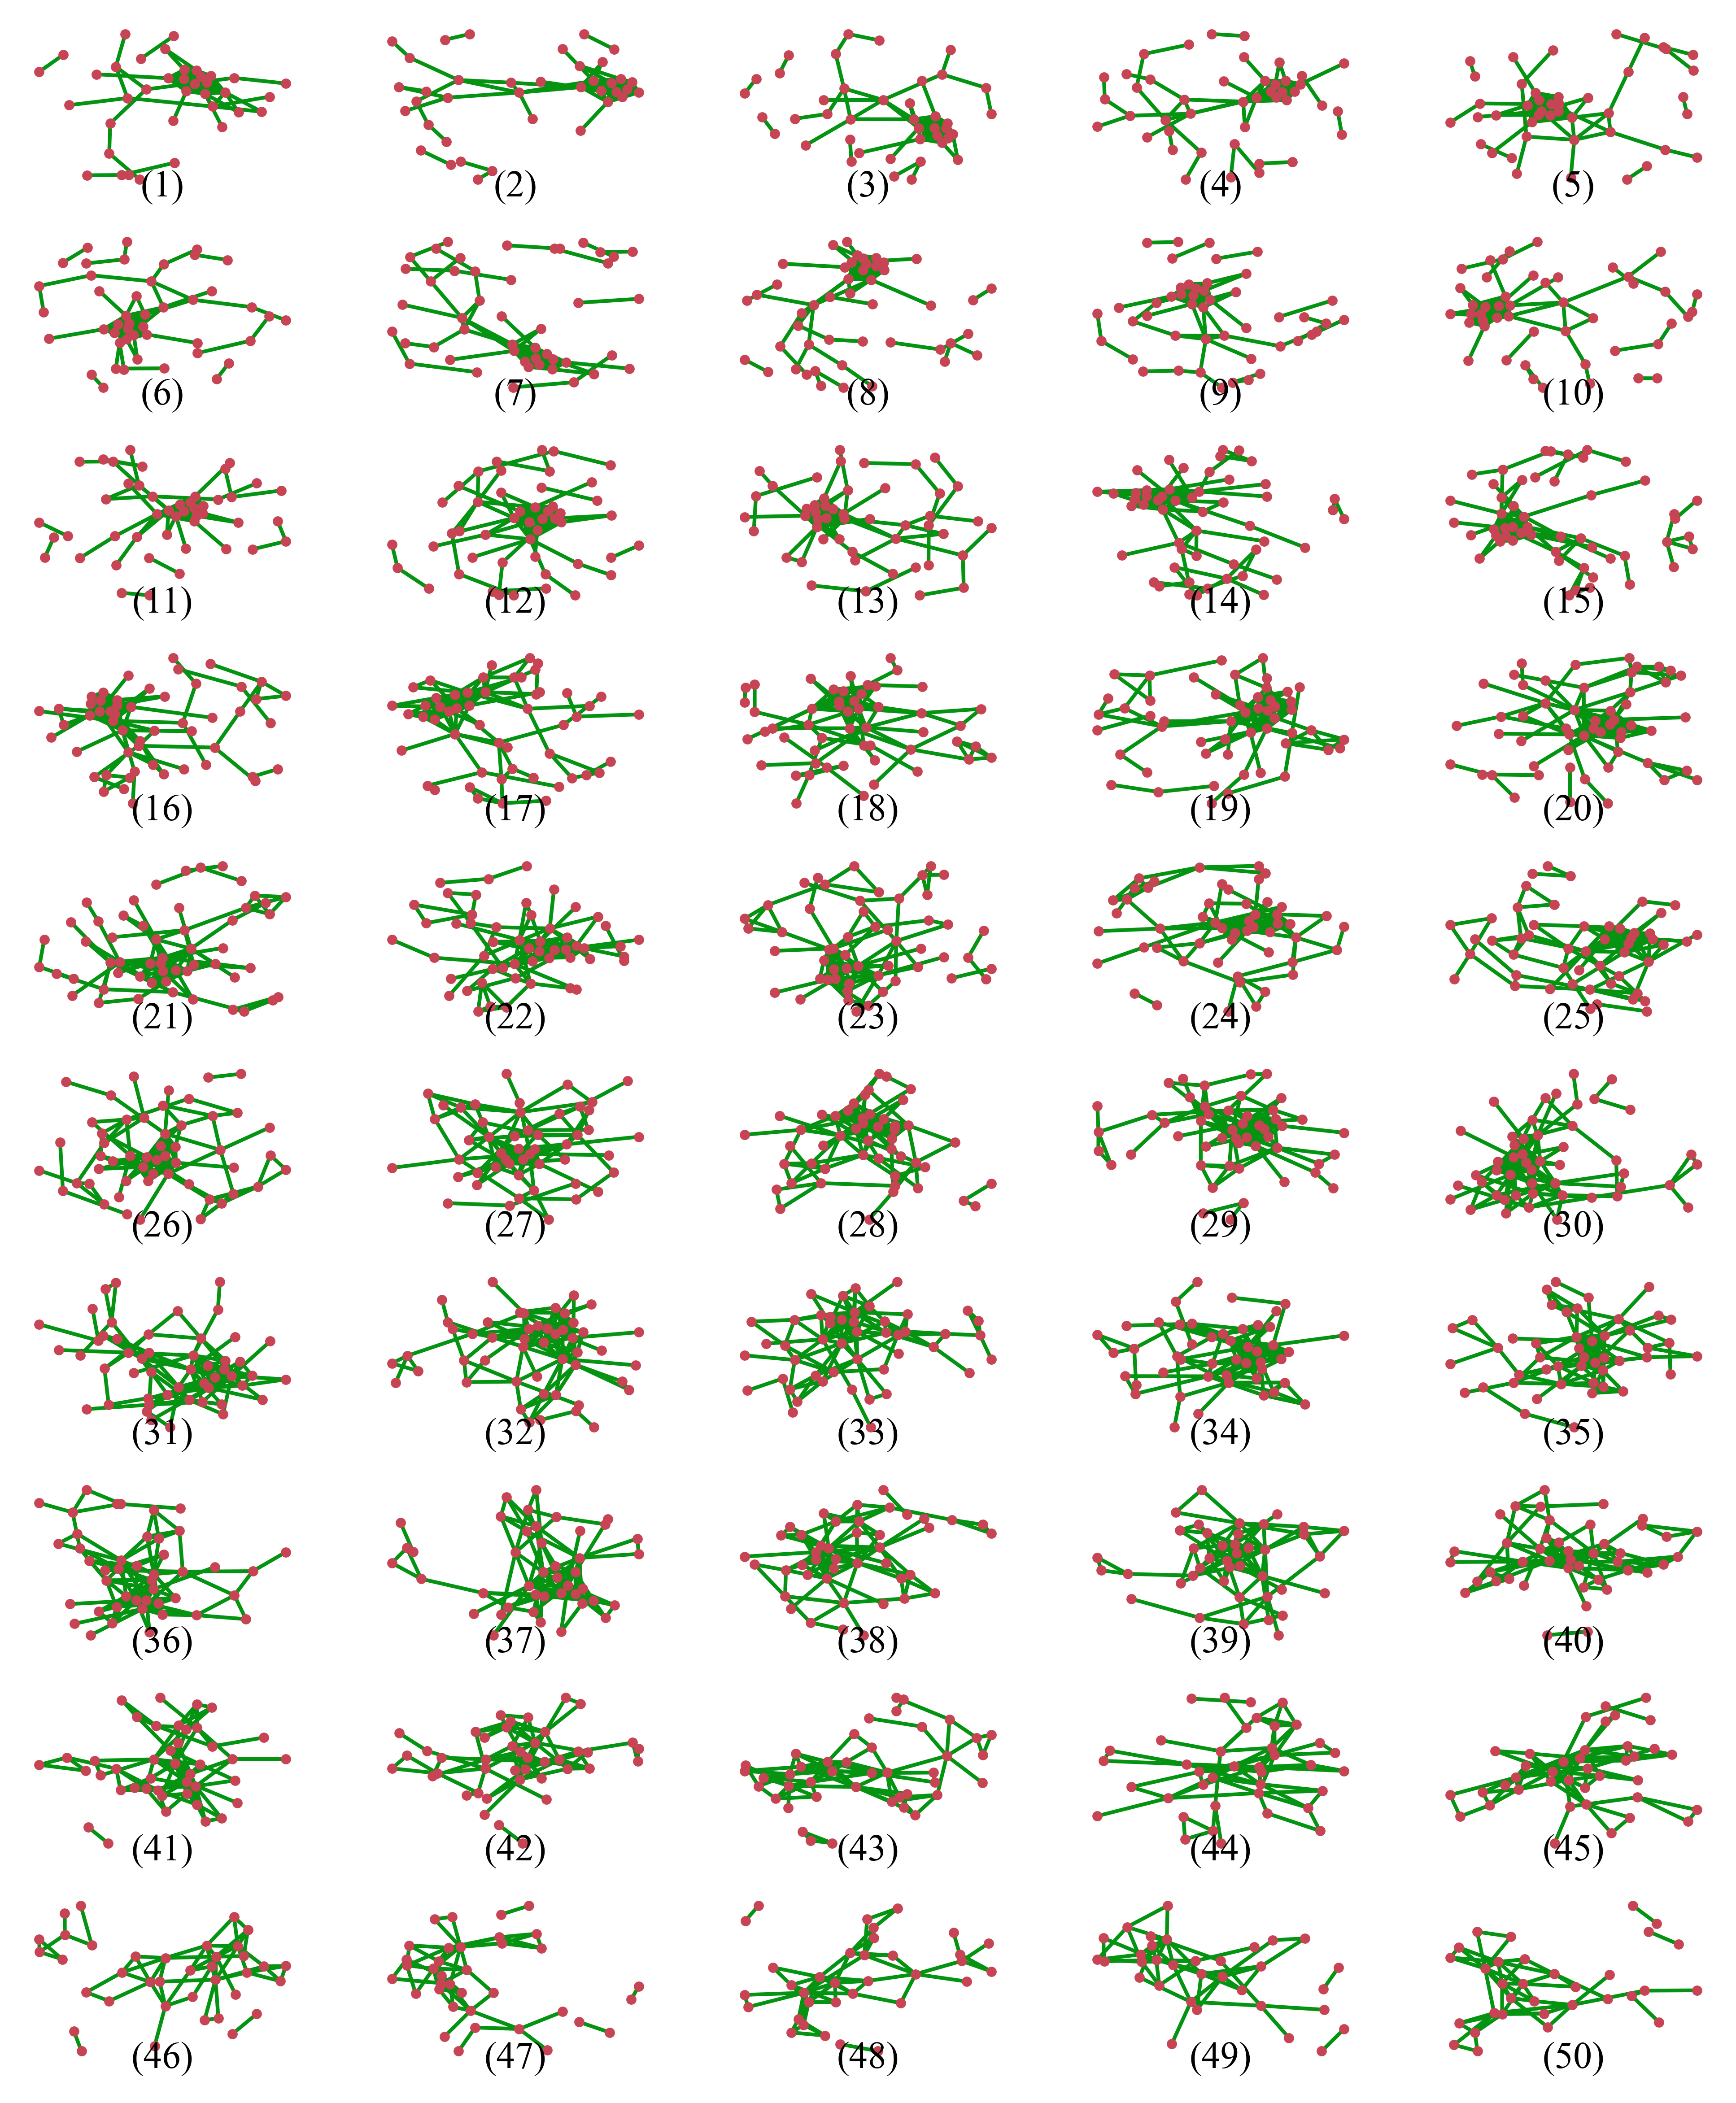

In [112]:
#import matplotlib.pyplot as plt
mydata = SFHH
mynodes = ij
d = np.zeros(120)
font_size = 10
fig = plt.figure(figsize=(25,10),dpi = 600)
t = 1800   ###一次选取30分钟的数据
b = 60 #滑动5分钟 
#fig.subplots_adjust(hspace=0.4, wspace=0.1)
gs = fig.add_gridspec(nrows=10,ncols=5,left=0.05,right=0.3,wspace=0.3,hspace=0.3) 
for N in range(50):
    bb = b*N
    ax = fig.add_subplot(gs[N//5, N%5])
    ax.set_title('('+str(N+1)+')',y=-0.2,
              fontdict = {'family' : 'Times New Roman','size': font_size})
    G = nx.Graph()
    for i in range(len(mydata)):
        if mydata['time'][i] >= mydata['time'][0]+bb:
            if mydata['time'][i] <= mydata['time'][0]+bb+ t:
                G.add_edge(mydata['i'][i],mydata['j'][i])
            else:
                break        
    pos = nx.spring_layout(G,k=0.5)
#    pos = nx.kamada_kawai_layout(G,dist = 0.5)

    #E0346D
    #6B124F
#    pos = nx.random_layout(G)
    nx.draw(G, pos=pos,node_color = '#C64453',edge_color = '#049412',node_size = 3,width = 1,with_labels = False)  # Draw the original graph
    
    #186665
    #049412

    
#plt.savefig('E:/Desktop/wxy/结果/figure3.eps',bbox_inches='tight',pad_inches=0.0)
plt.savefig('E:/Desktop/毕业论文/论文1/202307结果/figures/wangluo_figure.svg',bbox_inches='tight',pad_inches=0.0)

In [101]:
#import matplotlib.pyplot as plt
mydata = SFHH
mynodes = ij
nodes_n = np.zeros(data_n)
edges_n = np.zeros(data_n)
t = 1800   ###一次选取30分钟的数据
b = 60 #滑动5分钟 
for N in range(data_n):
    bb = b*N
    G = nx.Graph()
    for i in range(len(mydata)):
        if mydata['time'][i] >= mydata['time'][0]+bb:
            if mydata['time'][i] <= mydata['time'][0]+bb+ t:
                G.add_edge(mydata['i'][i],mydata['j'][i])
            else:
                break        
    nodes_n[N] = len(G.nodes())
    edges_n[N] = len(G.edges())

In [102]:
#print(nodes_n)
print(max(nodes_n))
#nodes_n.index(max(nodes_n))
print(np.argmax(nodes_n)+1)

print(min(nodes_n))
#nodes_n.index(max(nodes_n))
print(np.argmin(nodes_n)+1)

m = max(nodes_n)
print([i for i, j in enumerate(nodes_n) if j == m])
mm = min(nodes_n)
print([i for i, j in enumerate(nodes_n) if j == mm])

339.0
454
12.0
655
[453]
[654, 655, 656, 657]


In [103]:
edges_n
#print(edges_n)
print(max(edges_n))
#nodes_n.index(max(nodes_n))
print(np.argmax(edges_n)+1)

print(min(edges_n))
#nodes_n.index(max(nodes_n))
print(np.argmin(edges_n)+1)

m = max(edges_n)
print([i for i, j in enumerate(edges_n) if j == m])
mm = min(edges_n)
print([i for i, j in enumerate(edges_n) if j == mm])

2181.0
880
13.0
655
[879]
[654, 655, 656, 657]


In [104]:
edges_n_var = np.zeros(120)
for i in range(119):
    edges_n_var[i] = edges_n[i+1]-edges_n[i]
edges_n_var    

array([  2.,   2.,   2.,   0.,   1.,   1.,   0.,   3.,   2.,   5.,   4.,
         4.,   5.,   1.,   9., -13.,   2.,   0.,   2.,  -5.,  -1.,   0.,
         0.,   0.,   1.,   4.,  -1.,   2.,   1.,   2.,  -2.,  -3.,  -3.,
        -1.,  -2.,  -2.,   0.,  -4.,  -1.,  -7.,  -7.,  -2.,  -7.,  -2.,
        -7.,  -2.,  -1.,  -4.,  -1.,  -1.,   1.,   0.,   0.,  -4.,  -3.,
        -4.,   1.,  -4.,  -7.,  -2.,  -3.,   0.,   0.,   2.,  -1.,   1.,
         0.,   0.,  -1.,   1.,  -1.,  12.,   7.,   6.,   9.,   9.,  10.,
         7.,   2.,  -1.,   0.,   0.,  22.,   4.,   4.,   6.,   0.,   3.,
         1.,   3.,   1.,   2.,   2.,   0.,  -3.,  -2.,   2.,   3.,   3.,
        12.,   9.,  17.,  26.,  19.,  19.,  36.,  20.,  16.,  11.,  21.,
        40.,  52.,  21.,  32.,  36.,  46.,  19.,  25.,  44.,   0.])

In [105]:
import cv2

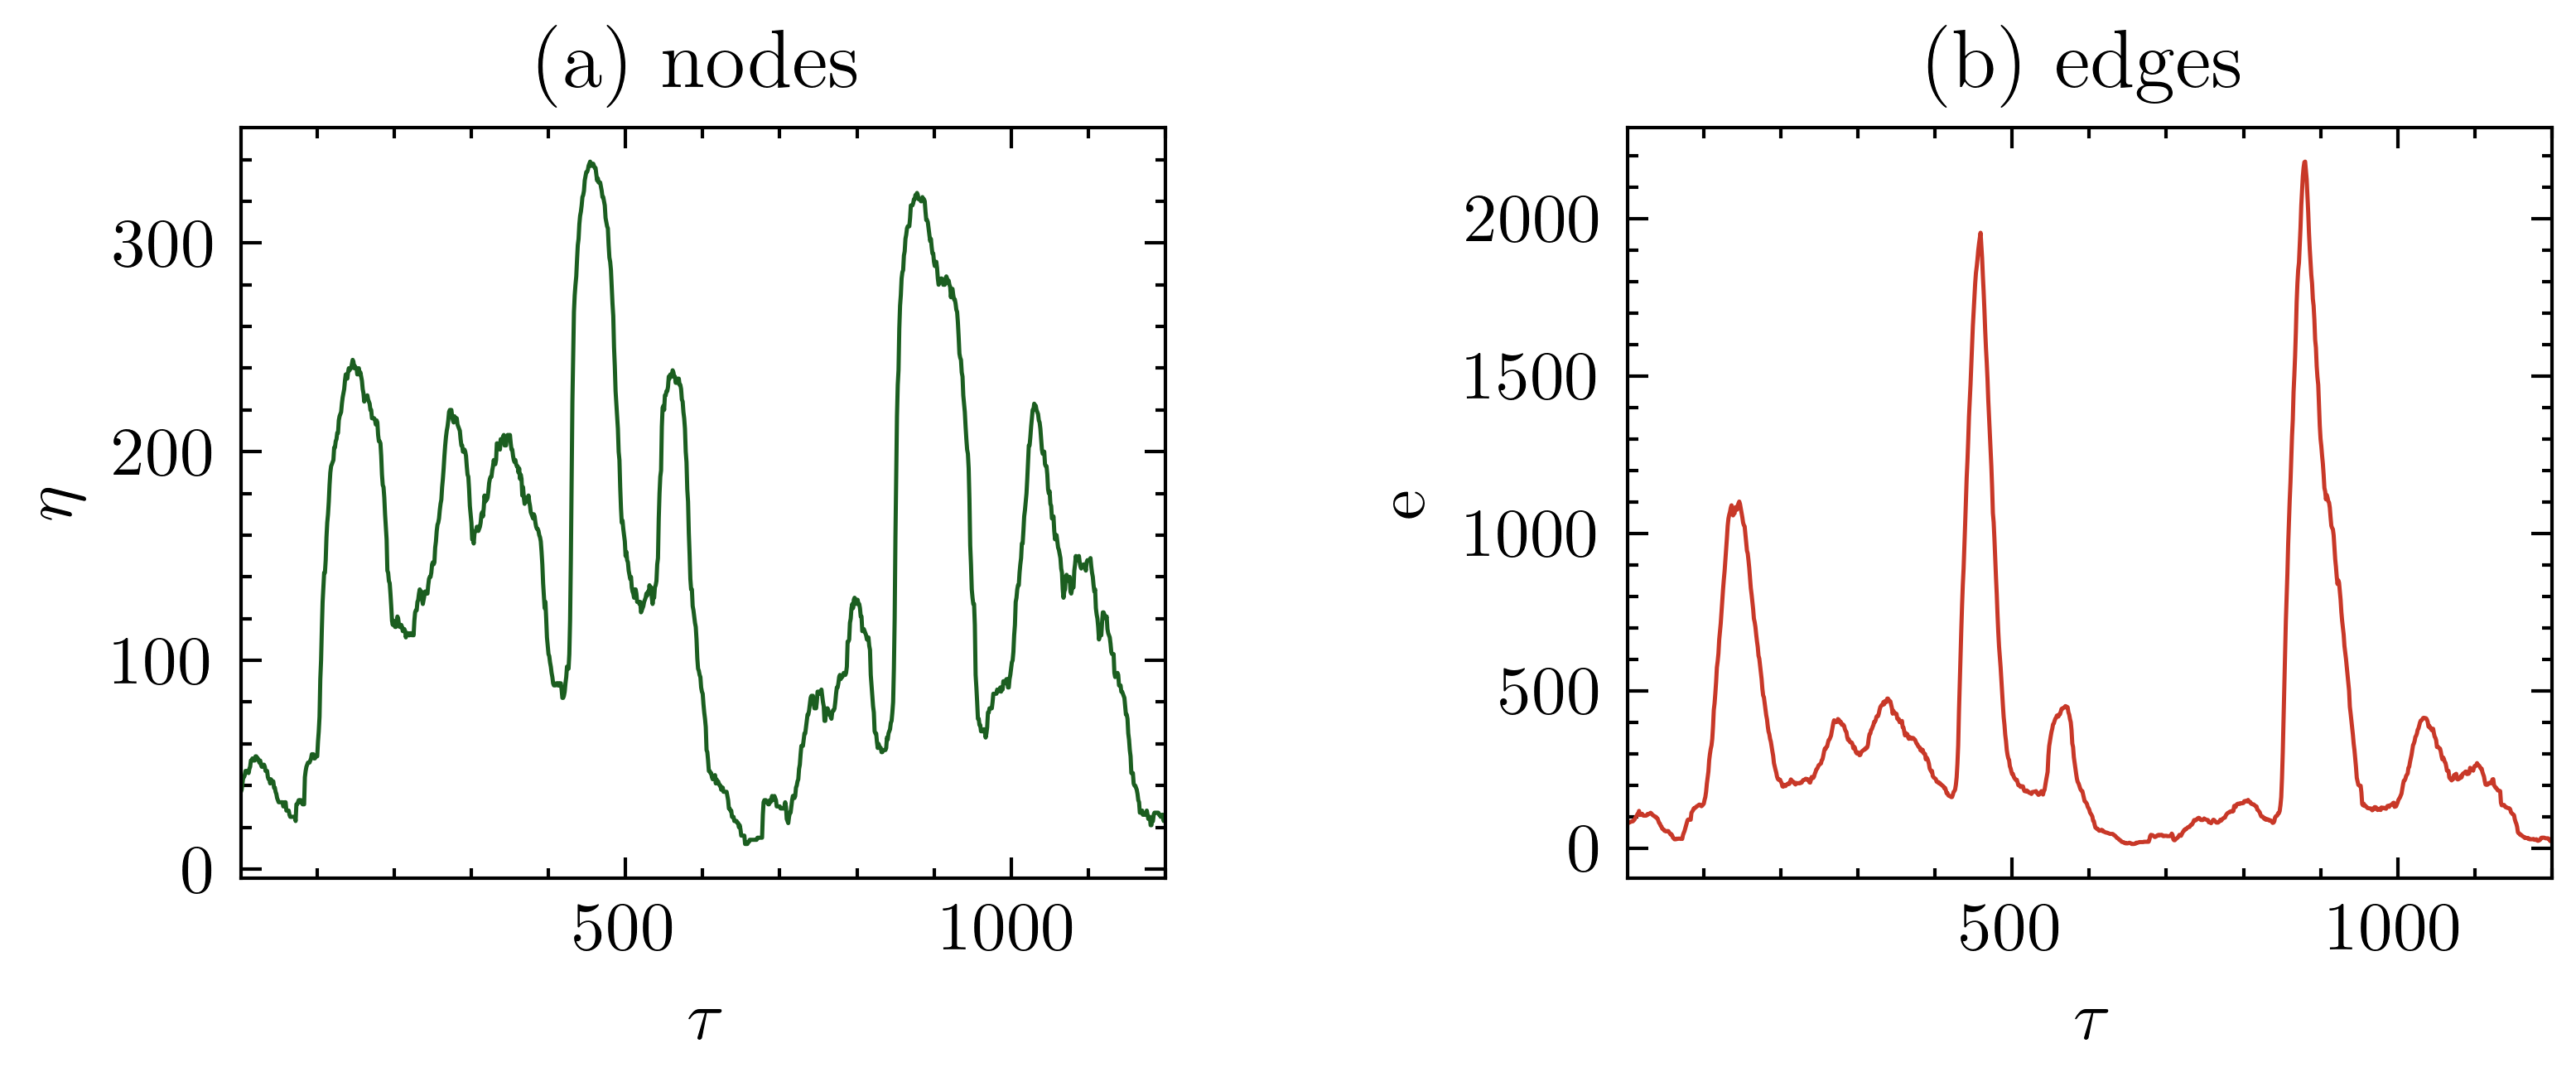

In [124]:
#plt.plot(nodes_n)
#plt.plot(edges_n)

plt.style.use('science') # ieee

linecolor = ('#1B5E20','#C83828','#4d5aaf')
plt.figure(figsize=(6,2),dpi=600)
plt.subplots_adjust(hspace=0.1, wspace=0.5)
font_size = 6
line_width = 0.6
plt.subplot(1,2,1)
plt.plot(np.arange(1,data_n+1),nodes_n, color=linecolor[0],linewidth = line_width,label = 'nodes')
plt.xlabel(r'$\tau$')

plt.title('(a) nodes')
#plt.yticks((0,100,200,300,400),fontproperties='Times New Roman', size=font_size)#设置大小及加粗
#plt.xticks((1,30,60,90,120),fontproperties='Times New Roman', size=font_size)
plt.xlim(1,data_n)
#plt.ylim(0,400)
plt.ylabel(r'$\eta$')



plt.subplot(1,2,2)
plt.plot(np.arange(1,data_n+1),edges_n, color=linecolor[1],linewidth = line_width,label = 'edges')
plt.xlabel(r'$\tau$')
plt.title('(b) edges')
#plt.yticks((0,500,1000,1500,2000),fontproperties='Times New Roman', size=font_size)#设置大小及加粗
#plt.xticks(fontproperties='Times New Roman', size=font_size)
plt.xlim(1,data_n)
#plt.ylim(0,2000)
plt.ylabel('e')
#plt.legend(ncol=1,
#           prop = {'family' : 'Times New Roman','size': font_size},
#          frameon = False) # 显示图例

plt.savefig('E:/Desktop/毕业论文/论文1/202307结果/figures/figure4.svg',bbox_inches='tight',pad_inches=0.0)

In [5]:
mydata = SFHH
mynodes = ij
gn = np.zeros(len(mynodes))
ij_n = len(mynodes)
for N in range(len(A)): 
    myA = A[N]
    for j in range(ij_n):
        if np.count_nonzero(myA[j]) != 0:
            gn[j] = gn[j] + 1


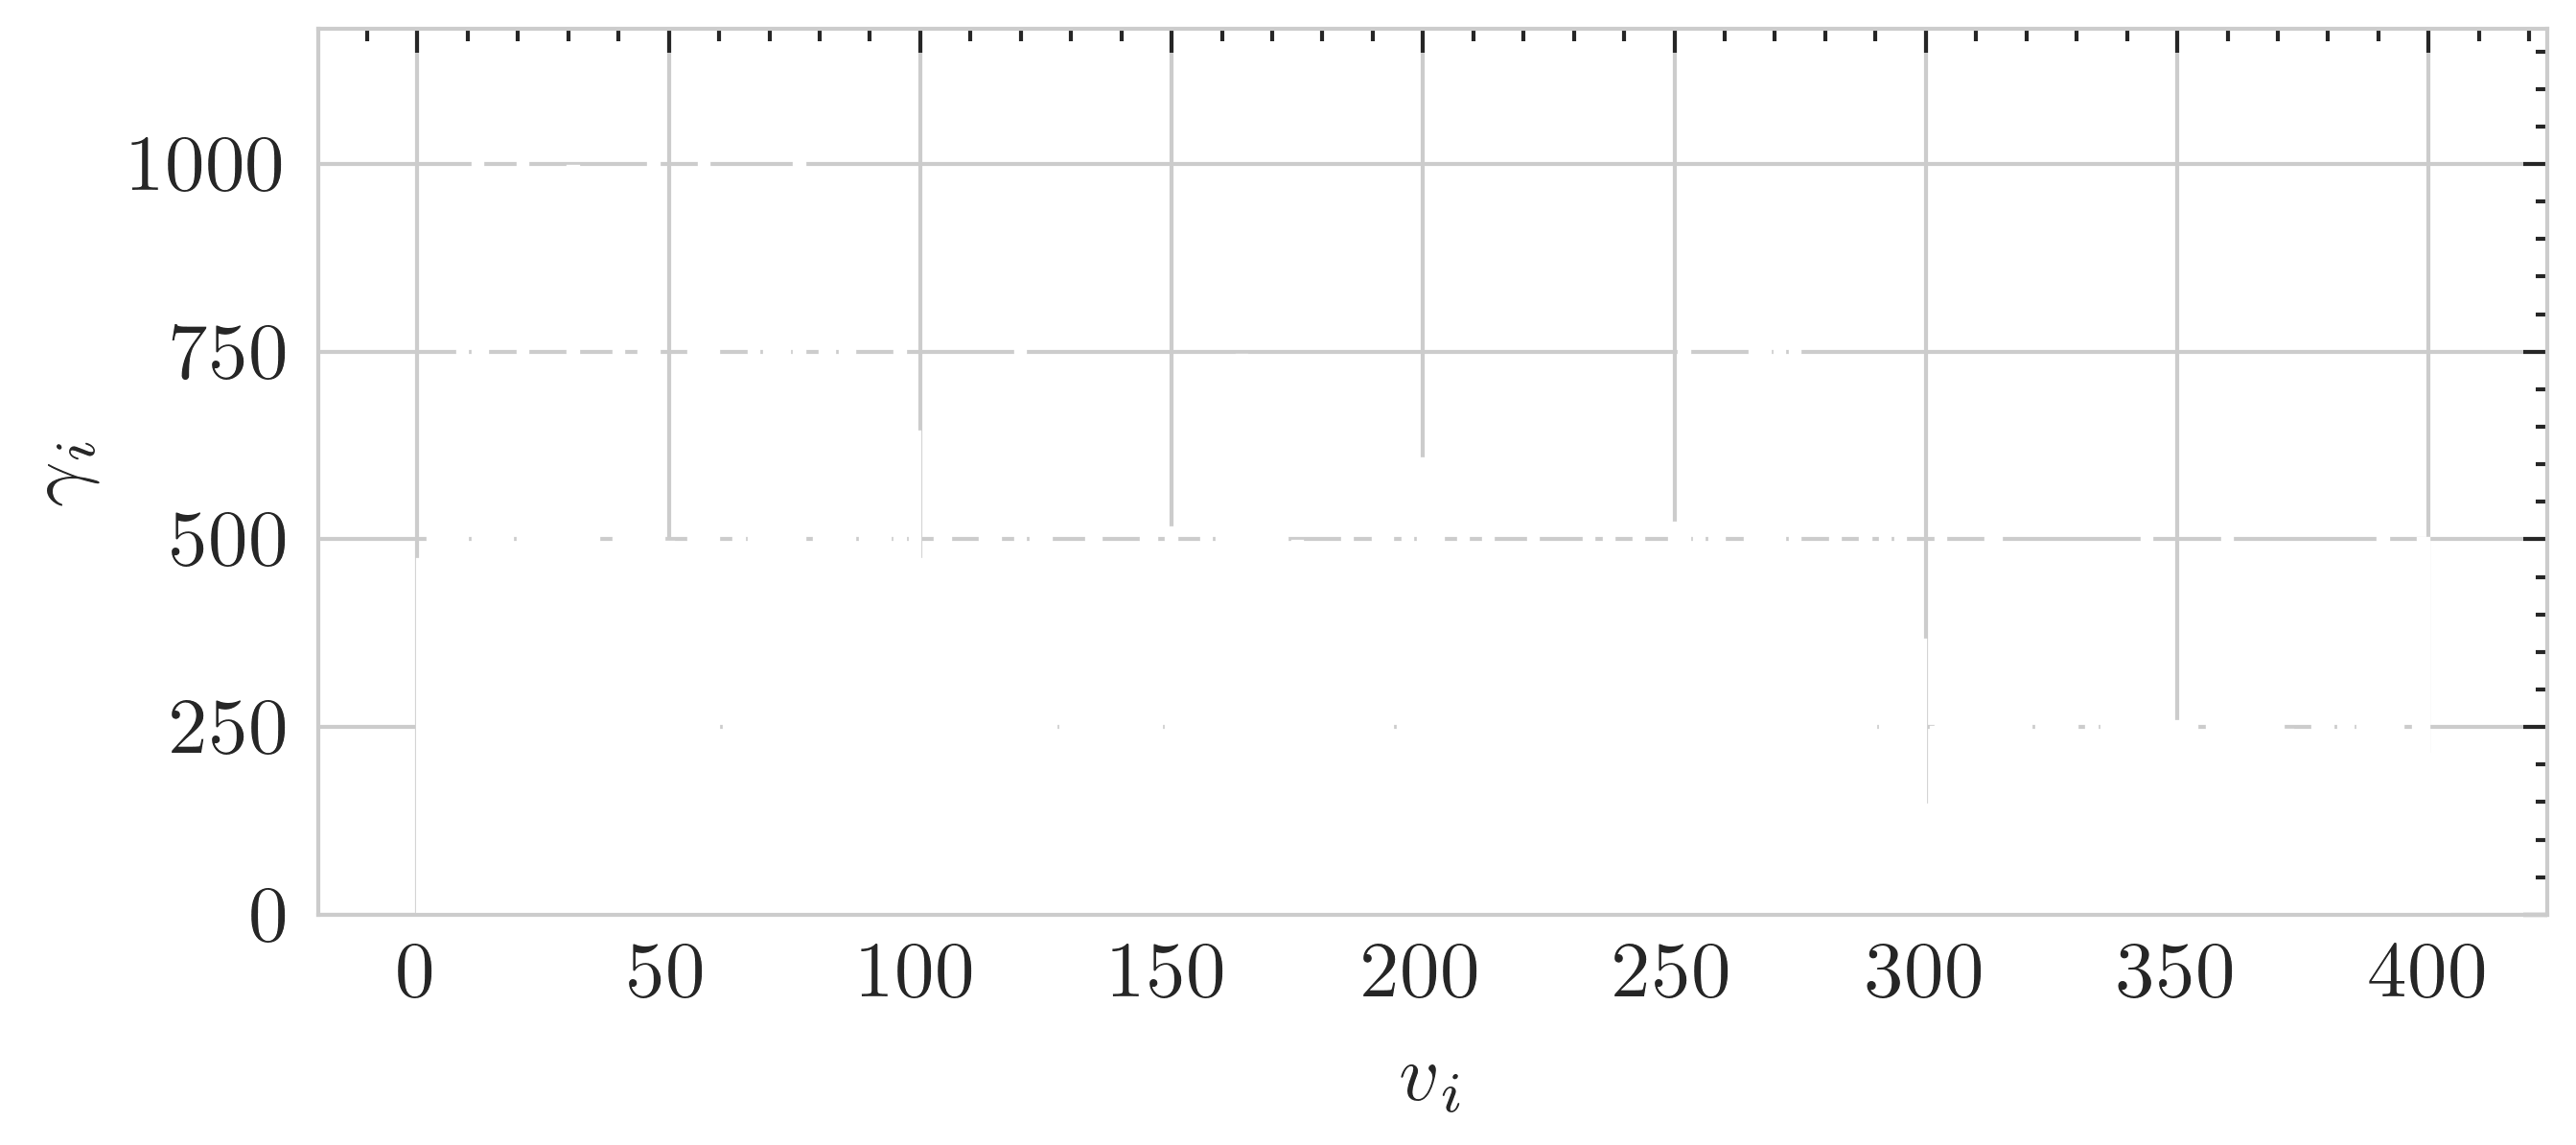

<Figure size 350x262.5 with 0 Axes>

In [3]:
mydata = SFHH
mynodes = ij
gn = np.zeros(len(mynodes))
ij_n = len(mynodes)
for N in range(len(A)): 
    myA = A[N]
    for j in range(ij_n):
        if np.count_nonzero(myA[j]) != 0:
            gn[j] = gn[j] + 1
plt.figure(figsize=(5,2),dpi=600)
#plt.plot(gn,'ro')
plt.style.use('science') # ieee

font_size = 6
plt.bar(np.arange(1,len(gn)+1),gn, width=1,color = 'b')
plt.xlabel('${v}$$_i$',fontdict = {'family' : 'Times New Roman'})
#plt.text(40,-1220 ,'(b) edges', fontdict = {'family' : 'Times New Roman','size': font_size})
#plt.yticks((0,40,80,120),fontproperties='Times New Roman', size=font_size)#设置大小及加粗
#plt.xticks((1,100,200,300,400),fontproperties='Times New Roman', size=font_size)
#plt.xlim(1,402)
#plt.ylim(0,125)
plt.ylabel(r'$\gamma$'+'$_i$')
plt.show()
#plt.savefig('E:/Desktop/毕业论文/论文1/202307结果/figures/figure5.svg',bbox_inches='tight',pad_inches=0.0)
plt.savefig('E:/figures/Fig_5.pdf',bbox_inches='tight',pad_inches=0.0)

In [12]:

print(max(gn))
#nodes_n.index(max(nodes_n))
print(np.argmax(gn)+1)

print(min(gn))
#nodes_n.index(max(nodes_n))
print(np.argmin(gn)+1)


m = max(gn)
print([i+1 for i, j in enumerate(gn) if j == m])
mm = min(gn)
print([i+1 for i, j in enumerate(gn) if j == mm])

1124.0
21
31.0
402
[21]
[402]
